<h1 style="text-align:center;">Clusterização de produtos no Mercado Livre BR

# <a id='sumario'></a>Sumário
1. [**Entendimento do projeto**](#entendimento-do-problema)
2. [**Bibliotecas**](#bibliotecas)
<br>
3. [**Entendimento dos Dados**](#entendimento-dos-dados)       
- 3.1 [Carregando os Dados](#carregando-os-dados)
- 3.2 [Descritiva dos dados](#descritiva-dos-dados)
4. [**Transformação nos dados**](#transformacao-nos-dados)
5. [**Modelagem**](#Modelagem)
- 5.1 [Testes de Clusters e Variáveis](#Clusters-e-variáveis)  
- 5.2 [Kmeans](#K-means)    

<a id='entendimento-do-projeto'></a>
# 1. Entendimento do projeto

Em um mercado cada vez mais competitivo, a pesquisa de mercado é fundamental para entender as tendências, identificar oportunidades e tomar decisões informadas. Ela pode revelar informações valiosas sobre a demanda do consumidor, ajudando empresas a otimizar suas estratégias de preços, marketing e estoque para maximizar os lucros.

O projeto segue um fluxo eficiente: começa com a extração de dados da **API do Mercado Livre** usando o Apache Airflow, armazena esses dados em um Data Lake na nuvem, processa os dados com um modelo de Machine Learning (**K-means**) e apresenta os resultados no Streamlit. Este fluxo é implementado em várias plataformas, incluindo AWS, GCP e uma configuração local gratuita.

<a id='bibliotecas'></a>
# 2. Bibliotecas

In [1]:
import pandas as pd
import gcsfs
import json
import matplotlib.pyplot as plt
import seaborn as sns

from google.oauth2 import service_account
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

<a id='entendimento-dos-dados'></a>
# 3. Entendimento dos Dados

A api do mercado livre apresenta várias funcionalidades incluindo os dados sobre os produtos que estão online na plataforma, e informações sobre eles avaliações e visitas. Assim o airflow extraiu essas informações e particionou os dados no Bucket, iremos usar os dados da categoria Celulares e Telefones para treianmento do modelo, utilizaremos variáveis comuns para todas categorias. Alémdos produtos, tembém carrega a lista trends, que são as maiores pesquisas por categorias feitas por usuários e clientes da plataforma.

<a id='carregando-os-dados'></a>
## 3.1 Carregando os Dados

In [2]:
# Chave de acesso conta de serviço google cloud
key_path = "C:\\Users\\user\\OneDrive\\Documentos\\Data Science\\Api\\Extração de dados api python\\Projeto api e mercado livre\\Chave Json conta serviço google cloud\\deft-approach-412320-e0afe84e0783.json"

# Cria as credenciais
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

# Cria um objeto de sistema de arquivos com as credenciais
fs = gcsfs.GCSFileSystem(project='deft-approach-412320', token=credentials)

# Lendo os dados dos produtos salvos no bucket da cloud
with fs.open('itens-meli/Celulares e Telefones/dados.json') as dados:
    df = pd.read_json(dados)
    
# Lendo os dados das tendências salvos no bucket da cloud
with fs.open('itens-meli/Celulares e Telefones/tendencias.json') as tendencias:
    trends_data = json.load(tendencias)

# Extrai apenas os valores da 'keyword' e armazena em uma lista
trend = [item['keyword'] for sublist in trends_data for item in sublist]

In [3]:
trend

['pulseira apple watch',
 'headphone',
 'bateria 12v',
 'uber',
 'intelbras',
 'ringlinght celular',
 'pelicula camera iphone',
 'acessorios celulares',
 'fone de ouvidos',
 'cabo usb',
 'xiaomi 14 pro titanium',
 'vivo x100 pro',
 'display apple watch',
 'nubia z60 ultra',
 'bateria a10',
 'bateria iphone x',
 'chip diretinho',
 'capas celular blu 6 polegadas',
 'numero virtual whatsapp',
 'm1906f9sh',
 'bateria motorola one action',
 'telefone rural 5g',
 'loja oficial motorola',
 'celular guitarrinha original',
 'tela apple watch',
 'capa com nfc capas celular',
 'celular tela 7 5 polegadas',
 'telefone ks panasonic kx t7730',
 'capa celular multilaser',
 'pera phone original',
 'telefone',
 'xiaomi poco x gb',
 'capas e peliculas',
 'huawei',
 'apple',
 'pecas para celulares',
 'a05s',
 '15 pro max',
 'recarga celular',
 'anel inteligente',
 'celular xiaomi redmi c',
 'iphone 15 pro max case',
 'meizu 21',
 'celular rural',
 'celular game',
 's8',
 'redmi k70',
 'loja samsung ofici

In [4]:
df.head()

,ID do produto,Preço,Marca,Modelo,Link,Título,Categoria,Visitas,Estrelas
0,MLB3427723135,919.00,Samsung,A14 (Exynos) Dual SIM,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A14 5g 128gb 4gb Ram Preto,Celulares e Telefones,21989,4.8
1,MLB4186567120,949.05,Samsung,A24,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A24 128 Gb Preto 4 Gb Ram,Celulares e Telefones,12596,4.8
2,MLB4199953938,471.96,Samsung,A03 Core Dual SIM,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A03 Core Dual Sim 32 Gb Black 2...,Celulares e Telefones,25838,4.7
3,MLB3497242371,1426.98,Motorola,G54 Dual SIM (eSIM),https://www.mercadolivre.com.br/smartphone-mot...,Smartphone Motorola Moto G54 5g 256gb 8gb Ram ...,Celulares e Telefones,25878,N/A
4,MLB3584941189,199.00,Positivo,P51,https://www.mercadolivre.com.br/celular-featur...,Celular Featurephone Positivo P51 4g 48mb 128m...,Celulares e Telefones,598,N/A


<a id='descritiva-dos-dados'></a>
## 3.2 Descritiva dos dados

In [5]:
df.describe()

,Preço
count,998.000000
mean,947.520481
std,1051.689793
min,8.900000
25%,175.412500
50%,746.875000
75%,1298.750000
max,10481.050000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID do produto  998 non-null    object 
 1   Preço          998 non-null    float64
 2   Marca          995 non-null    object 
 3   Modelo         997 non-null    object 
 4   Link           998 non-null    object 
 5   Título         998 non-null    object 
 6   Categoria      998 non-null    object 
 7   Visitas        998 non-null    object 
 8   Estrelas       998 non-null    object 
dtypes: float64(1), object(8)
memory usage: 70.3+ KB


<a id='transformacao-nos-dados'></a>
# 4. Transformação nos dados

In [7]:
# Remove as linhas com valores NaN
df = df.dropna()

In [8]:
# Dados NaN em string
(df['Visitas']=='N/A').sum()
(df['Estrelas']=='N/A').sum()

853

In [9]:
# Imputa 'N/A' com -1
df['Visitas'].replace('N/A', -1, inplace=True)
df['Estrelas'].replace('N/A', -1, inplace=True)

In [10]:
# Cria novas colunas para as versões padronizadas
df['Visitas_pad'] = (df['Visitas'] - df['Visitas'].mean()) / df['Visitas'].std()
df['Estrelas_pad'] = (df['Estrelas'] - df['Estrelas'].mean()) / df['Estrelas'].std()
df['Preço_pad'] = (df['Preço'] - df['Preço'].mean()) / df['Preço'].std()

# Cria as novas colunas baseadas nas colunas padronizadas
df['preco_por_visita'] = df['Preço_pad'] / df['Visitas_pad']
df['preco_por_estrela'] = df['Preço_pad'] / df['Estrelas_pad']

In [11]:
df.head()

,ID do produto,Preço,Marca,Modelo,Link,Título,Categoria,Visitas,Estrelas,Visitas_pad,Estrelas_pad,Preço_pad,preco_por_visita,preco_por_estrela
0,MLB3427723135,919.00,Samsung,A14 (Exynos) Dual SIM,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A14 5g 128gb 4gb Ram Preto,Celulares e Telefones,21989,4.8,3.385748,3.120813,-0.029701,-0.008772,-0.009517
1,MLB4186567120,949.05,Samsung,A24,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A24 128 Gb Preto 4 Gb Ram,Celulares e Telefones,12596,4.8,1.848735,3.120813,-0.001139,-0.000616,-0.000365
2,MLB4199953938,471.96,Samsung,A03 Core Dual SIM,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A03 Core Dual Sim 32 Gb Black 2...,Celulares e Telefones,25838,4.7,4.015575,3.060842,-0.454604,-0.113210,-0.148523
3,MLB3497242371,1426.98,Motorola,G54 Dual SIM (eSIM),https://www.mercadolivre.com.br/smartphone-mot...,Smartphone Motorola Moto G54 5g 256gb 8gb Ram ...,Celulares e Telefones,25878,-1.0,4.022120,-0.357472,0.453125,0.112658,-1.267581
4,MLB3584941189,199.00,Positivo,P51,https://www.mercadolivre.com.br/celular-featur...,Celular Featurephone Positivo P51 4g 48mb 128m...,Celulares e Telefones,598,-1.0,-0.114544,-0.357472,-0.714048,6.233853,1.997492


In [12]:
df['Visitas/Estrelas'] = df['Visitas'] / df['Estrelas']

In [13]:
df.head()

,ID do produto,Preço,Marca,Modelo,Link,Título,Categoria,Visitas,Estrelas,Visitas_pad,Estrelas_pad,Preço_pad,preco_por_visita,preco_por_estrela,Visitas/Estrelas
0,MLB3427723135,919.00,Samsung,A14 (Exynos) Dual SIM,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A14 5g 128gb 4gb Ram Preto,Celulares e Telefones,21989,4.8,3.385748,3.120813,-0.029701,-0.008772,-0.009517,4581.041667
1,MLB4186567120,949.05,Samsung,A24,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A24 128 Gb Preto 4 Gb Ram,Celulares e Telefones,12596,4.8,1.848735,3.120813,-0.001139,-0.000616,-0.000365,2624.166667
2,MLB4199953938,471.96,Samsung,A03 Core Dual SIM,https://www.mercadolivre.com.br/samsung-galaxy...,Samsung Galaxy A03 Core Dual Sim 32 Gb Black 2...,Celulares e Telefones,25838,4.7,4.015575,3.060842,-0.454604,-0.113210,-0.148523,5497.446809
3,MLB3497242371,1426.98,Motorola,G54 Dual SIM (eSIM),https://www.mercadolivre.com.br/smartphone-mot...,Smartphone Motorola Moto G54 5g 256gb 8gb Ram ...,Celulares e Telefones,25878,-1.0,4.022120,-0.357472,0.453125,0.112658,-1.267581,-25878.000000
4,MLB3584941189,199.00,Positivo,P51,https://www.mercadolivre.com.br/celular-featur...,Celular Featurephone Positivo P51 4g 48mb 128m...,Celulares e Telefones,598,-1.0,-0.114544,-0.357472,-0.714048,6.233853,1.997492,-598.000000


<a id='Modelagem'></a>
# 5. Modelagem

<a id='Clusters-e-variáveis'></a>
## 5.1 Testes de Clusters e Variáveis

**Regra do Cotovelo (Elbow Rule)**: É uma técnica usada para ajudar a determinar o número ideal de clusters em um algoritmo de agrupamento. O método envolve o cálculo da soma das distâncias quadradas (SSE) para diferentes números de clusters (k), e a escolha do valor de k que causa uma queda acentuada ou "cotovelo" no gráfico da SSE versus k.

\begin{equation}
SSE = \sum_{i=1}^{k} \sum_{x \in C_i} \lVert x - \mu_i \rVert^2
\end{equation}

Onde:
- \\(SSE\\) é a soma das distâncias quadradas.
- \\(C_i\\) é o i-ésimo cluster.
- \\(x\\) é um ponto de dados no cluster.
- \\(\\mu_i\\) é o centróide do cluster.

**Método da Silhueta (Silhouette Method)**: É outra técnica usada para determinar o número ideal de clusters. Ele mede a qualidade do agrupamento calculando a distância média entre cada ponto de dados e todos os outros pontos no mesmo cluster (coesão), e a distância média entre cada ponto de dados e todos os outros pontos no cluster mais próximo (separação). O valor da silhueta varia de -1 a 1, onde um valor alto indica que o ponto de dados está bem combinado com seu próprio cluster e mal combinado com os clusters vizinhos.

\begin{equation}
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
\end{equation}

Onde:
- \\(s(i)\\) é o coeficiente de silhueta para o ponto de dados i.
- \\(a(i)\\) é a distância média de i para os pontos de dados no mesmo cluster.
- \\(b(i)\\) é a menor distância média de i para os pontos de dados em qualquer outro cluster.


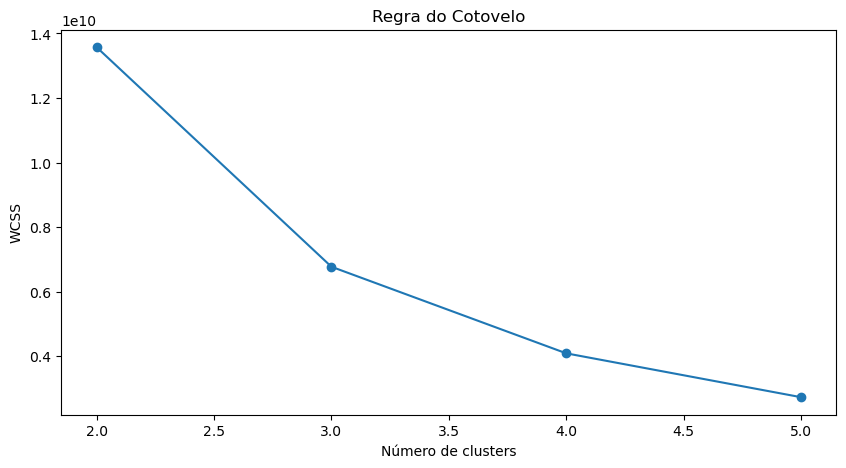

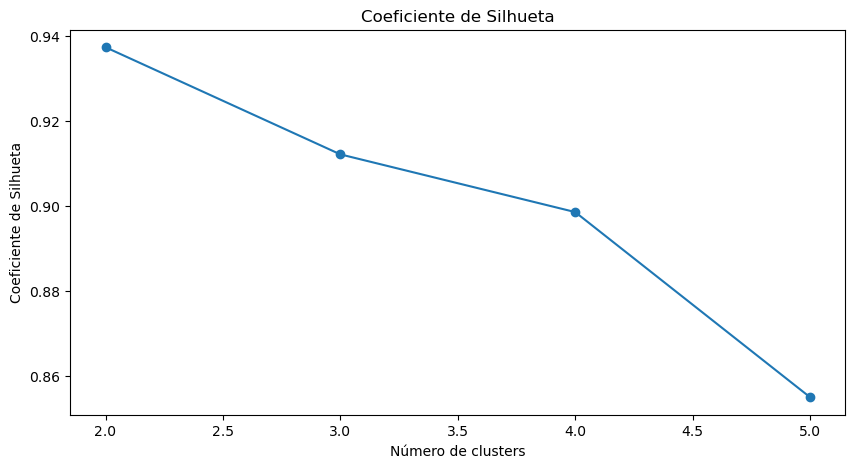

In [14]:
# Conjunto de dados treino
X = df[['Preço', 'Visitas','Estrelas']]

# Lista para armazenar os valores de WCSS (Within-Cluster Sum of Square)
wcss = []
# Lista para armazenar os valores do coeficiente de silhueta
silhouette_scores = []

# Calcula o WCSS e o coeficiente de silhueta para diferentes números de clusters
for i in range(2, 6):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=123).fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plota a regra do cotovelo
plt.figure(figsize=(10,5))
plt.plot(range(2, 6), wcss, marker='o')
plt.title('Regra do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

# Plota o coeficiente de silhueta
plt.figure(figsize=(10,5))
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silhueta')
plt.show()

- Observa-se que **3 grupos** tendem a apresentar ótimos resultados de separação, o que encaixa com a ideia do projeto de separar em produtos e as variáveis não trasnformadas e não padronizadas forneceram melhor separação e entendimento dos clusters. Por isso vamos definir em 3 clusters e as variáveis "Preço", "Visitas" e "Estrelas"

<a id='K-means'></a>
## 5.2 Kmeans

O algoritmo K-means é um método de agrupamento que visa particionar n observações em k clusters nos quais cada observação pertence ao cluster com a média mais próxima. O algoritmo funciona iterativamente para atribuir cada ponto de dados ao cluster cujo centroide (a média aritmética de todos os pontos de dados que pertencem ao cluster) é o mais próximo. Ele continua fazendo isso até que a soma das distâncias quadradas dos pontos de dados de seus respectivos centroides de cluster não possa ser minimizada mais.

A fórmula para calcular o centróide de um cluster é a seguinte:

\begin{equation}
C_i = \frac{1}{n}\sum_{j=1}^{n} x_j
\end{equation}


Onde:

- (C_i) é o centróide do cluster.
- (n) é o número de pontos de dados no cluster.
- (x_j) é o j-ésimo ponto de dados no cluster.

In [15]:
# Cria o modelo KMeans com 3 clusters
kmeans_meli = KMeans(n_clusters=3, n_init=10, random_state=123)

# Ajusta o modelo aos dados
kmeans_meli.fit(X)

# Obtém os rótulos dos clusters
labels = kmeans_meli.labels_

# Adiciona os rótulos dos clusters ao seu DataFrame
df['Cluster'] = labels

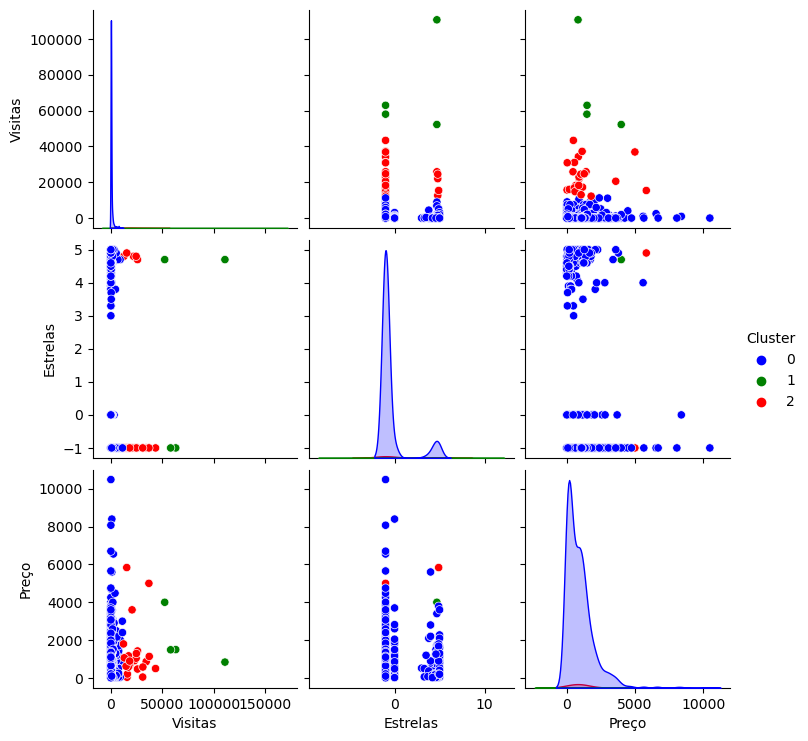

In [16]:
# Define a paleta de cores
palette = ["blue","green", "red"]

# pairplot com 4 grupos
sns.pairplot(df[['Visitas', 'Estrelas', 'Cluster', 'Preço']], hue='Cluster', palette=palette)
plt.show()

In [17]:
# Calcula a média de cada variável para cada cluster
median_values = X.groupby(df['Cluster']).median()

In [18]:
median_values

,Preço,Visitas,Estrelas
Cluster,,,
0,740.00,-1.0,-1.00
1,1494.00,60461.5,1.85
2,914.77,20542.0,-1.00


- Observamos que o cluster **0 (azul)**, se refere aos produtos novos, poucas visita ou sem avaliações. Mas com boa concentração de baixo preço **"Desconhecidos baratos"**
- Fica nítido que o cluster **1 (verde)**, representa o grupo **"Aclamados"**, tem uma media alta de Visitas e uma boa média de estrelas, porém uma média mais alta no preço.
- O grupo **2 (Vermelho)** Tem muitas visitas comparadas a avaliações e preço em conta, por isso vamos definir como **"Baratos de qualidade variada"**

In [19]:
# Define um dicionário que mapeia os rótulos dos clusters para os nomes dos grupos
cluster_names = {
    0: "Desconhecidos baratos",
    1: "Aclamados",
    2: "Baratos de qualidade variada"
}

# Cria uma nova coluna 'Grupo' que contém o nome do grupo para cada observação
df['Grupo'] = df['Cluster'].map(cluster_names)

In [20]:
from joblib import dump

# Suponha que 'model' é o seu modelo treinado
dump(kmeans_meli, 'kmeans_meli.joblib')

['kmeans_meli.joblib']